## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L2
"""
def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    if regularization =='l1':
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1), 
                                    kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1),
                                    kernel_regularizer=l1(ratio))(x)
    elif regularization =='l2':
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1), 
                                    kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1),
                                    kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1), 
                                    kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                    activation="relu", 
                                    name="hidden_layer"+str(i+1),
                                    kernel_regularizer=l1_l2(ratio))(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULARIZATION = ["l1", 'l2', 'l1_l2']
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regularization in REGULARIZATION:
    for regulizer_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], regularization=regularization, ratio=regulizer_ratio, output_units=10, num_neurons=[512, 256, 128])
        model.summary()
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = (f"Regularizer ratio: {regulizer_ratio}")
        results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1950 - loss: 300.0659 - val_accuracy: 0.2421 - val_loss: 40.9833
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1558 - loss: 27.2499 - val_accuracy: 0.1000 - val_loss: 7.2545
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1006 - loss: 5.2531 - val_accuracy: 0.1000 - val_loss: 2.6421
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0977 - loss: 2.5239 - val_accuracy: 0.1000 - val_loss: 2.4625
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0990 - loss: 2.4626 - val_accuracy: 0.1000 - val_loss: 2.4624
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0989 - loss: 2.4626 - val_accuracy: 0.1000 - val_loss: 2.4625
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0988 - loss: 2.4626 - val_accuracy: 0.1000 - val_loss: 2.4626
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0988 - loss: 2.4626 - val_accura

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2189 - loss: 6.1300 - val_accuracy: 0.3502 - val_loss: 5.7971
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3604 - loss: 5.7508 - val_accuracy: 0.3891 - val_loss: 5.6193
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3923 - loss: 5.5923 - val_accuracy: 0.4116 - val_loss: 5.4973
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4139 - loss: 5.4669 - val_accuracy: 0.4246 - val_loss: 5.3859
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4303 - loss: 5.3561 - val_accuracy: 0.4404 - val_loss: 5.2814
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4454 - loss: 5.2508 - val_accuracy: 0.4502 - val_loss: 5.1932
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4535 - loss: 5.1634 - val_accuracy: 0.4530 - val_loss: 5.1109
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4637 - loss: 5.0679 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2128 - loss: 2.1557 - val_accuracy: 0.3459 - val_loss: 1.8666
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3612 - loss: 1.8338 - val_accuracy: 0.3818 - val_loss: 1.7569
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3960 - loss: 1.7373 - val_accuracy: 0.4114 - val_loss: 1.6824
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4187 - loss: 1.6640 - val_accuracy: 0.4244 - val_loss: 1.6439
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4363 - loss: 1.6158 - val_accuracy: 0.4253 - val_loss: 1.6163
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4479 - loss: 1.5756 - val_accuracy: 0.4457 - val_loss: 1.5672
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4595 - loss: 1.5369 - val_accuracy: 0.4541 - val_loss: 1.5453
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4704 - loss: 1.5104 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.2170 - loss: 2.1441 - val_accuracy: 0.3450 - val_loss: 1.8622
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3625 - loss: 1.8328 - val_accuracy: 0.3869 - val_loss: 1.7568
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.3930 - loss: 1.7308 - val_accuracy: 0.3987 - val_loss: 1.6960
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4120 - loss: 1.6691 - val_accuracy: 0.4231 - val_loss: 1.6401
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4367 - loss: 1.6116 - val_accuracy: 0.4347 - val_loss: 1.5950
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4494 - loss: 1.5718 - val_accuracy: 0.4491 - val_loss: 1.5640
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4607 - loss: 1.5386 - val_accuracy: 0.4466 - val_loss: 1.5548
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4668 - loss: 1.5147 - val

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2239 - loss: 15.6375 - val_accuracy: 0.3414 - val_loss: 13.9263
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3515 - loss: 13.4496 - val_accuracy: 0.3636 - val_loss: 12.1113
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3791 - loss: 11.7046 - val_accuracy: 0.3929 - val_loss: 10.5757
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4002 - loss: 10.2315 - val_accuracy: 0.4012 - val_loss: 9.2777
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4092 - loss: 8.9881 - val_accuracy: 0.4153 - val_loss: 8.1716
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4169 - loss: 7.9223 - val_accuracy: 0.4230 - val_loss: 7.2332
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4243 - loss: 7.0190 - val_accuracy: 0.4229 - val_loss: 6.4331
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4264 - loss: 6.2537 - val_accur

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2178 - loss: 2.2797 - val_accuracy: 0.3418 - val_loss: 1.9981
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3586 - loss: 1.9650 - val_accuracy: 0.3806 - val_loss: 1.8957
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3892 - loss: 1.8817 - val_accuracy: 0.4067 - val_loss: 1.8250
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4116 - loss: 1.8153 - val_accuracy: 0.4274 - val_loss: 1.7803
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4355 - loss: 1.7579 - val_accuracy: 0.4369 - val_loss: 1.7437
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4431 - loss: 1.7301 - val_accuracy: 0.4442 - val_loss: 1.7190
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4576 - loss: 1.6814 - val_accuracy: 0.4575 - val_loss: 1.6846
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4668 - loss: 1.6609 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2003 - loss: 2.1680 - val_accuracy: 0.3416 - val_loss: 1.8628
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3572 - loss: 1.8335 - val_accuracy: 0.3897 - val_loss: 1.7524
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3898 - loss: 1.7329 - val_accuracy: 0.4036 - val_loss: 1.6937
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4149 - loss: 1.6718 - val_accuracy: 0.4207 - val_loss: 1.6498
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4310 - loss: 1.6289 - val_accuracy: 0.4417 - val_loss: 1.6010
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4445 - loss: 1.5826 - val_accuracy: 0.4432 - val_loss: 1.5799
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4578 - loss: 1.5506 - val_accuracy: 0.4556 - val_loss: 1.5505
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4642 - loss: 1.5199 - val_accu

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2101 - loss: 2.1501 - val_accuracy: 0.3443 - val_loss: 1.8670
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3540 - loss: 1.8322 - val_accuracy: 0.3816 - val_loss: 1.7535
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3970 - loss: 1.7275 - val_accuracy: 0.4034 - val_loss: 1.6910
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4116 - loss: 1.6727 - val_accuracy: 0.4261 - val_loss: 1.6352
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4312 - loss: 1.6226 - val_accuracy: 0.4260 - val_loss: 1.6169
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4456 - loss: 1.5851 - val_accuracy: 0.4491 - val_loss: 1.5762
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4623 - loss: 1.5429 - val_accuracy: 0.4573 - val_loss: 1.5567
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4665 - loss: 1.5150 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2024 - loss: 300.1716 - val_accuracy: 0.2277 - val_loss: 41.0562
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1478 - loss: 27.3128 - val_accuracy: 0.1000 - val_loss: 7.2941
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0997 - loss: 5.2917 - val_accuracy: 0.1000 - val_loss: 2.6500
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1006 - loss: 2.5266 - val_accuracy: 0.1000 - val_loss: 2.4624
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1006 - loss: 2.4626 - val_accuracy: 0.1000 - val_loss: 2.4625
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0995 - loss: 2.4626 - val_accuracy: 0.1000 - val_loss: 2.4625
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1005 - loss: 2.4625 - val_accuracy: 0.1000 - val_loss: 2.4624
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0997 - loss: 2.4626 - val_accuracy

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2193 - loss: 6.1414 - val_accuracy: 0.3467 - val_loss: 5.8002
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3612 - loss: 5.7497 - val_accuracy: 0.3872 - val_loss: 5.6290
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3904 - loss: 5.5963 - val_accuracy: 0.4085 - val_loss: 5.5029
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4149 - loss: 5.4686 - val_accuracy: 0.4091 - val_loss: 5.4046
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4277 - loss: 5.3629 - val_accuracy: 0.4301 - val_loss: 5.2991
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4433 - loss: 5.2563 - val_accuracy: 0.4430 - val_loss: 5.2041
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4579 - loss: 5.1569 - val_accuracy: 0.4484 - val_loss: 5.1148
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4643 - loss: 5.0723 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2063 - loss: 2.1729 - val_accuracy: 0.3398 - val_loss: 1.8882
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3480 - loss: 1.8536 - val_accuracy: 0.3797 - val_loss: 1.7794
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3875 - loss: 1.7516 - val_accuracy: 0.4031 - val_loss: 1.7069
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4082 - loss: 1.6919 - val_accuracy: 0.4216 - val_loss: 1.6563
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4211 - loss: 1.6506 - val_accuracy: 0.4312 - val_loss: 1.6175
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4385 - loss: 1.6055 - val_accuracy: 0.4444 - val_loss: 1.5847
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4534 - loss: 1.5588 - val_accuracy: 0.4515 - val_loss: 1.5561
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4619 - loss: 1.5287 - val_accuracy: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2138 - loss: 2.1760 - val_accuracy: 0.3482 - val_loss: 1.8702
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3555 - loss: 1.8430 - val_accuracy: 0.3818 - val_loss: 1.7602
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3890 - loss: 1.7410 - val_accuracy: 0.4046 - val_loss: 1.7007
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4119 - loss: 1.6774 - val_accuracy: 0.4207 - val_loss: 1.6537
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4289 - loss: 1.6297 - val_accuracy: 0.4369 - val_loss: 1.6152
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4418 - loss: 1.5908 - val_accuracy: 0.4476 - val_loss: 1.5805
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4537 - loss: 1.5585 - val_accuracy: 0.4546 - val_loss: 1.5534
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4656 - loss: 1.5267 - val_accuracy: 0.

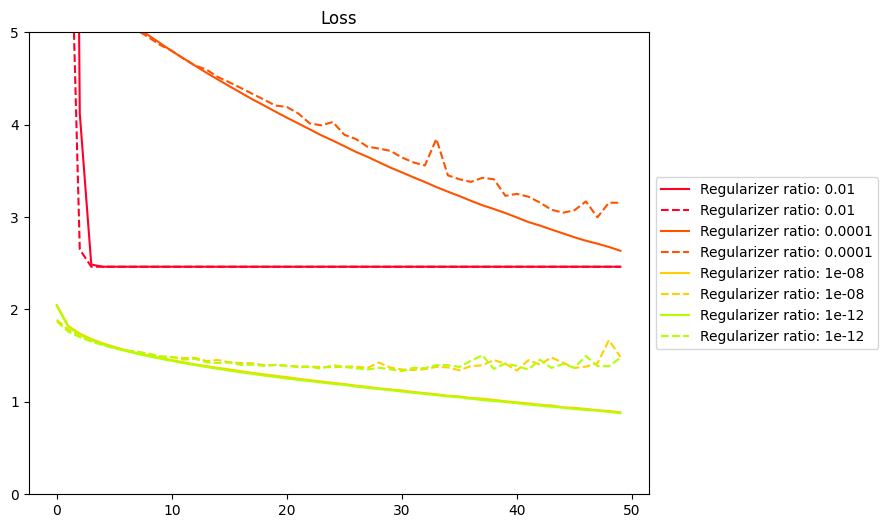

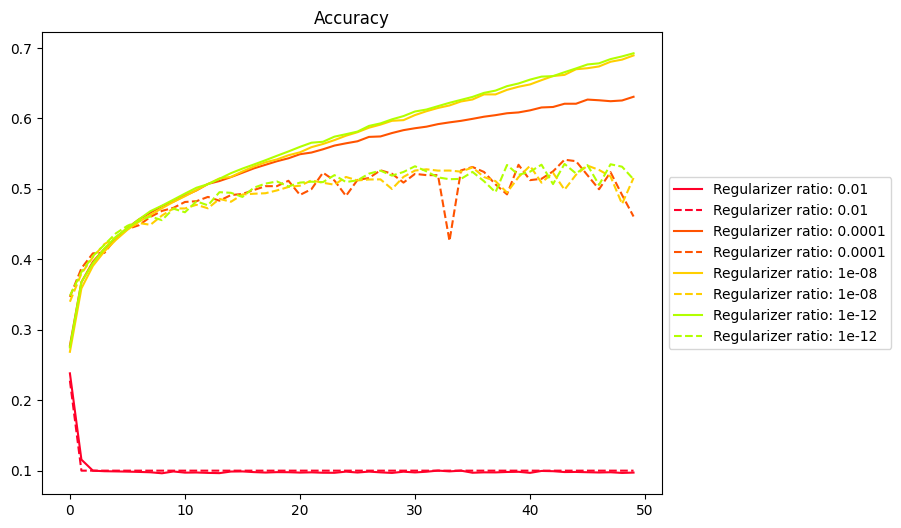

In [10]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()